In [1]:
# Load basic packages
import numpy as np
import pandas as pd

import autograd.numpy as numpy
import autograd.numpy.random as npr

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn import metrics
from sklearn import model_selection

# Useful for saving our models.
import pickle
print("Imported all!")

Imported all!


In [2]:
df = pd.read_csv('diabetes.csv')
df = df.dropna()
diabetes = df.values
print(diabetes.shape)

(253680, 22)


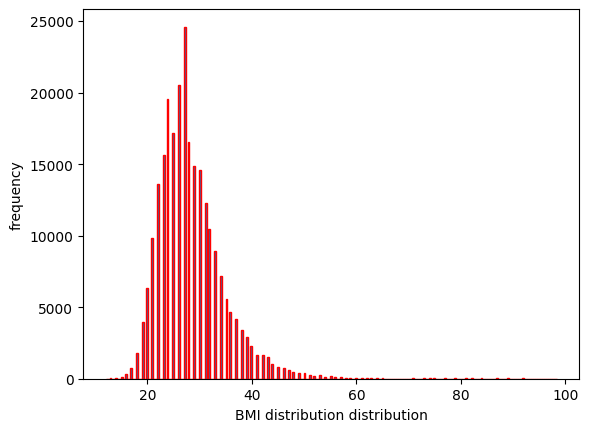

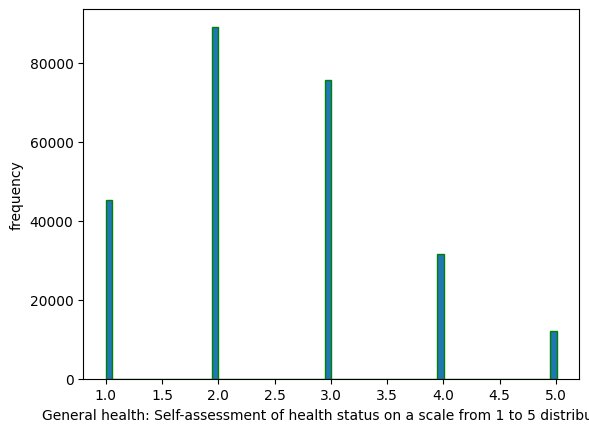

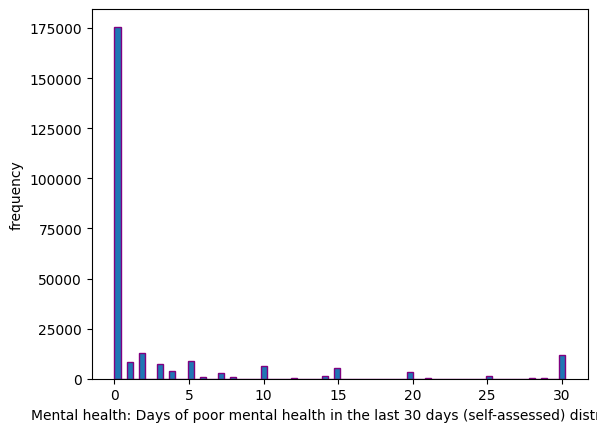

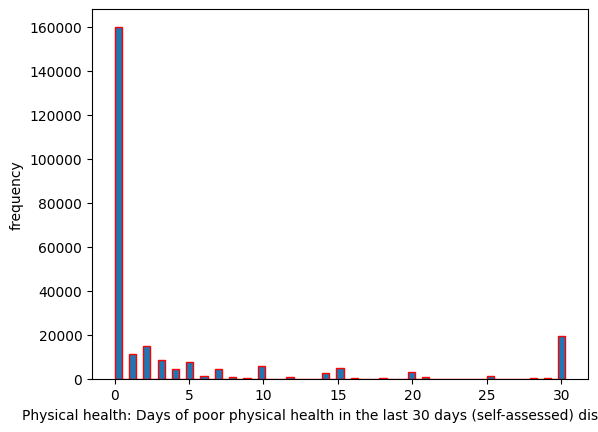

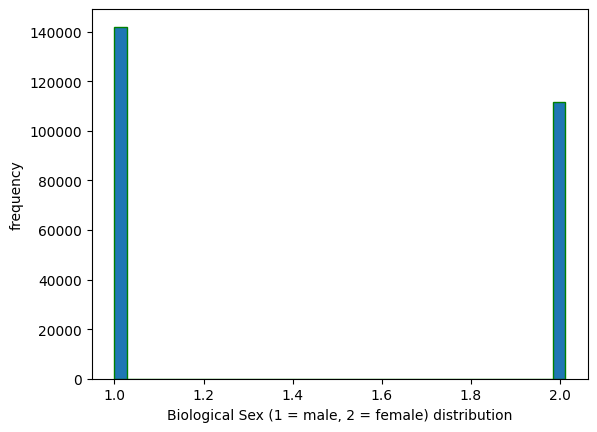

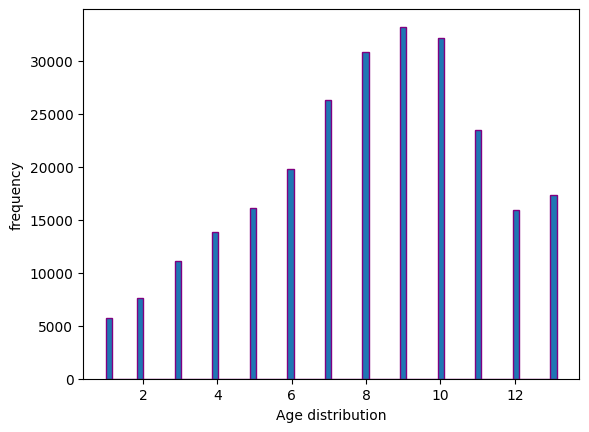

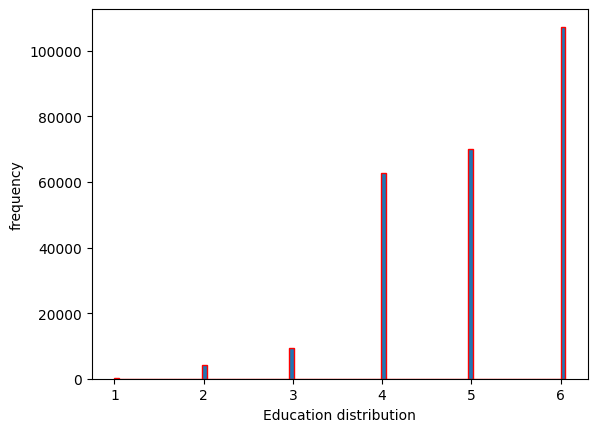

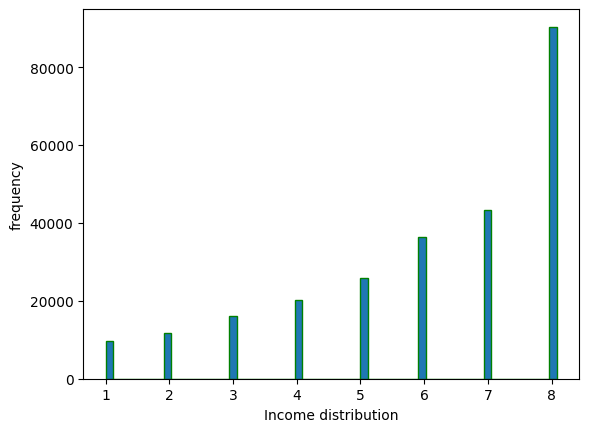

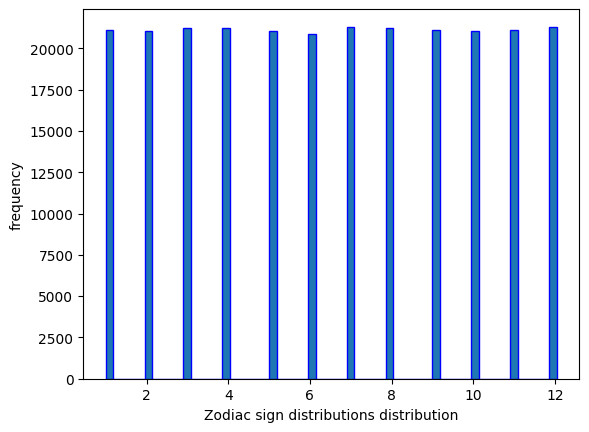

In [3]:
def plot_freq_dist(predictor_col, color: str = "red", title = "N/A"):
    """
    data: 1d dataframe to plot on the graph
    """
    data = predictor_col
    data_size = data.shape[0]
    # Let's use the Scott's rule for choosing the right bin width
    w = 3.49 * np.std(data)/data_size**(1./3)

    # define number of bins with accordance to the appropriate size 
    bins = np.arange(data.min().item(), data.max().item() + w, w, dtype=float)

    plt.hist(data, edgecolor=color, bins=bins) 
    plt.xlabel("{} distribution".format(title))  # Set x-axis label
    plt.ylabel("frequency")     # Set y-axis label
    plt.show()  # Show the plot

# let's plot continious variables
plot_freq_dist(diabetes[:, 3], color="red", title="BMI distribution")
plot_freq_dist(diabetes[:, 13], color="green", title="General health: Self-assessment of health status on a scale from 1 to 5")
plot_freq_dist(diabetes[:, 14], color="purple", title="Mental health: Days of poor mental health in the last 30 days (self-assessed)")
plot_freq_dist(diabetes[:, 15], color="red", title="Physical health: Days of poor physical health in the last 30 days (self-assessed)")
plot_freq_dist(diabetes[:, 17], color="green", title="Biological Sex (1 = male, 2 = female)")

# bracketed ordinal variables
plot_freq_dist(diabetes[:, 18], color="purple", title="Age")
plot_freq_dist(diabetes[:, 19], color="red", title="Education")
plot_freq_dist(diabetes[:, 20], color="green", title="Income")

# zodiac sign
plot_freq_dist(diabetes[:, 21], color="blue", title="Zodiac sign distributions")

In [4]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Sample data
data = diabetes

# Define columns
categorical_cols = [17, 21]  # Indices of categorical columns (sex + zodiac sign)
# We are not going to touch the ordinal data anyhow, since it is already giving the appropriate weights to the model
# ordinal_cols = [18, 19, 20]  # Indices of ordinal columns (age, education, income)
continuous_cols = [3, 13, 14, 15]  # Indices of continuous columns (BMI, general health, mental health, physical health)

# One-Hot Encoding for categorical variables

# pass the numpy column to the data to make this transofrmantion happen
def categorical_to_ohe(data, col_idx):
    one_hot_encoded_data = []
    categorical_column = data[:, col_idx]
    
    # for col_idx in categorical_cols:
    unique_values = np.unique(categorical_column)
    for value in unique_values[:-1]:  # Exclude the last category to avoid the dummy variable trap
        one_hot_encoded_data.append((data[:, col_idx] == value).astype(int))
    
    return np.array(one_hot_encoded_data).T

# Normalization for continuous variables (using Min-Max scaling to scale between 0 and 1)
def normalize_continious_variables(data, col_idx):
    # define min max scaler
    scaler = MinMaxScaler()
    # transform data
    scaled = scaler.fit_transform(data[:, col_idx].reshape(-1, 1))
    return scaled

def standardize_ordinal_variables(data, col_idx):
    # define standard scaler
    scaler = StandardScaler()
    # transform data
    scaled = scaler.fit_transform(data[:, col_idx].reshape(-1, 1))
    return scaled

In [23]:
# transform the sex column into OHE
sex_one_hot_encoded = categorical_to_ohe(data, 17)
# print("Shape of the one hot encoded data for the categorical col (sex): ", sex_one_hot_encoded.shape)

zodiac_one_hot_encoded = categorical_to_ohe(data, 21)
print("Shape of the one hot encoded data for the categorical col (zodiac sign): ", zodiac_one_hot_encoded.shape)

# Scale the continious variables
normalized_BMI = normalize_continious_variables(data, 3)
# print("Shape of the normalized data for the continuous col (BMI): ", normalized_BMI.shape)

normalized_general_health = normalize_continious_variables(data, 13)
# print("Shape of the normalized data for the continuous col (General Health): ", normalized_general_health.shape)

normalized_mental_health = normalize_continious_variables(data, 14)
# print("Shape of the normalized data for the continuous col (Mental Health): ", normalized_mental_health.shape)

normalized_physical_health = normalize_continious_variables(data, 15)
# print("Shape of the normalized data for the continuous col (Physical Health): ", normalized_physical_health.shape)

# Let's now scale the ordinal columns (bracket values)
normalized_age = normalize_continious_variables(data, 18)
# print("Shape of the normalized data for the continuous col (Age): ", normalized_age.shape)

normalized_education = normalize_continious_variables(data, 19)
# print("Shape of the normalized data for the continuous col (Education): ", normalized_education.shape)

normalized_income = normalize_continious_variables(data, 20)
# print("Shape of the normalized data for the continuous col (Income): ", normalized_income.shape)


ready_to_use_columns_p1 = [1, 2]
ready_to_use_columns_p2 = [i for i in range(4, 14)]

# Now, combine all the columns back together
processed_data = np.concatenate((
    # 1 and 2 are as is
    data[:, ready_to_use_columns_p1],
    # BMI is normalized
    normalized_BMI,
    # [4-13] are as is
    data[:, ready_to_use_columns_p2],
    # health predictors are normalized
    normalized_general_health, 
    normalized_mental_health, 
    normalized_physical_health,
    # 16 is as is
    data[:, 16].reshape(-1, 1),
    # 17 is OHE
    sex_one_hot_encoded,
    # age, education, and income brackets are normalized
    normalized_age,
    normalized_education, 
    normalized_income,
    # # zodiac sign is one hot encoded
    # zodiac_one_hot_encoded
), axis=1)


column_names = [
    "High blood pressure", 
    "High cholesterol", 
    "Body Mass Index", 
    "Smoker", 
    "Stroke", 
    "Myocardial issues", 
    "Physically active", 
    "Eats fruit", 
    "Eats vegetables", 
    "Heavy Drinker", 
    "Has healthcare", 
    "Cannot Afford Doctor", 
    "General health", 
    "Mental health", 
    "Physical health", 
    "Hard to climb stairs", 
    "Biological sex", 
    "Age bracket", 
    "Education bracket", 
    "Income bracket"
    # "Zodiac sign"
]

Shape of the one hot encoded data for the categorical col (zodiac sign):  (253680, 11)


In [6]:
# Separate the outcome (y) from the features (X)
y = diabetes[:, 0]  # the outcome is in the first column
# X = processed_data[:, :-11]
X = processed_data
print(X.shape, y.shape)

(253680, 21) (253680,)


In [7]:
# Split the data.  DO NOT TOUCH THE TEST DATA FROM HERE ON!!
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y, test_size = 0.2) # 0.2 is 20% test data.

# Question 1: Logistic regression

In [26]:
# Import packages for building the logistic model
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()

# k-fold cross-validation.
# hyperparameters are tuned using the validation dataset
k = 10
splitter = model_selection.KFold(k)

In [27]:
# Compute cross-validation scores.
cv_scores = model_selection.cross_val_score(model, X_train, y_train, cv = splitter)

# Just computed the cross validation scores 
print("Model CV score = ", np.mean(cv_scores))

Model CV score =  0.8634943264293282


In [28]:
# Train your logistic regression model
model.fit(X_train, y_train)

LogisticRegression()

In [29]:
print("Test set score: {:.2f}".format(model.score(X_test, y_test)))

Test set score: 0.86


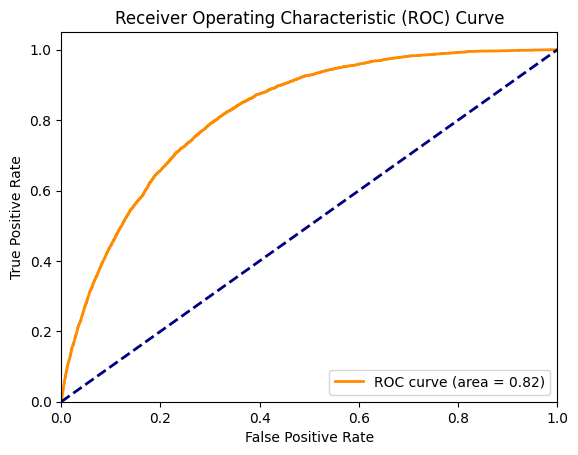

In [30]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

predicted_probabilities = model.predict_proba(X_test)[:, 1]
true_labels = y_test
fpr, tpr, thresholds = roc_curve(true_labels, predicted_probabilities)
auc_score = roc_auc_score(true_labels, predicted_probabilities)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [13]:
# # Save the model to a file
with open('logistic_regression_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# with open('logistic_regression_model.pkl', 'rb') as f:
#     model = pickle.load(f)

# with open('cross_validation_splitter.pkl', 'rb') as f:
#     splitter = pickle.load(f)

# # Save the splitter object to a file
with open('cross_validation_splitter.pkl', 'wb') as f:
    pickle.dump(splitter, f)

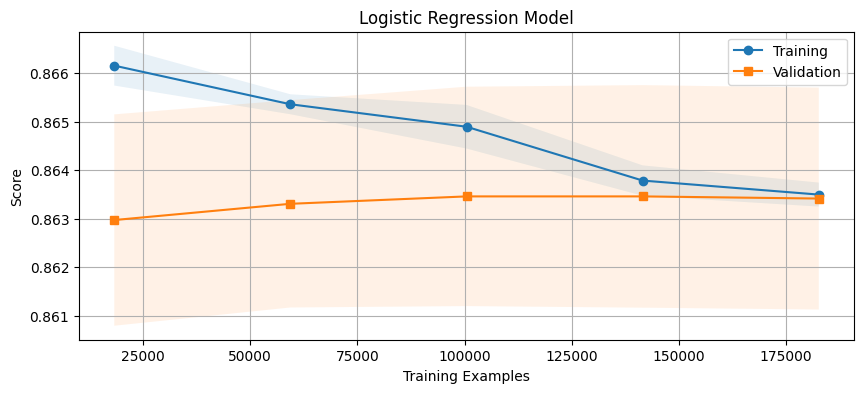

In [14]:
fig, ax = plt.subplots(figsize=(10, 4))

train_sizes, train_scores, test_scores = model_selection.learning_curve(model, X_train, y_train, cv=splitter)

# Compute means and std to reflect the stability of the models
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

ax.set_title('Logistic Regression Model')
ax.plot(train_sizes, train_scores_mean, 'o-', label='Training')
ax.plot(train_sizes, test_scores_mean, 's-', label='Validation')
ax.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1)
ax.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1)
ax.set_xlabel('Training Examples')
ax.set_ylabel('Score')
ax.grid()
ax.legend()

plt.show()

# Now since I have worked with a full model, let's explore which predictor is the best one in our case by systematically dropping predictors one by one

In [20]:
import numpy as np

def evaluate_predictor_importance(model, X_train, X_test, y_train, y_test, metric_func, drop_index):
    # Train the model
    model.fit(X_train, y_train)
    
    # Calculate initial evaluation metric
    initial_preds = model.predict_proba(X_test)[:, 1]
    initial_metric = metric_func(y_test, initial_preds)
    
    # Drop one predictor
    X_train_drop = np.delete(X_train, drop_index, axis=1)
    X_test_drop = np.delete(X_test, drop_index, axis=1)
    
    # Retrain the model without the dropped predictor
    model.fit(X_train_drop, y_train)
    
    # Calculate evaluation metric after dropping the predictor
    drop_preds = model.predict_proba(X_test_drop)[:, 1]
    drop_metric = metric_func(y_test, drop_preds)
    
    # Return the change in the evaluation metric
    return initial_metric - drop_metric
    

# Create a logistic regression model
log_reg = LogisticRegression()

# Specify the evaluation metric function (e.g., AUC)
metric_func = roc_auc_score

# Iterate through each predictor
auc_changes = []
for i in range(X_train.shape[1]):
    # Evaluate predictor importance
    auc_change = evaluate_predictor_importance(log_reg, X_train, X_test, y_train, y_test, metric_func, i)
    auc_changes.append(auc_change)

# Identify the predictor with the largest drop in AUC
most_important_predictor_index = np.argmax(auc_changes)
most_important_predictor = column_names[most_important_predictor_index]
largest_auc_drop = auc_changes[most_important_predictor_index]


print(f"Most important predictor is: {most_important_predictor} with index: {most_important_predictor_index}")
print(f"Largest AUC drop: {largest_auc_drop}")

Most important predictor is: Body Mass Index with index: 2
Largest AUC drop: 0.014504824212057121


ValueError: The number of FixedLocator locations (21), usually from a call to set_ticks, does not match the number of labels (20).

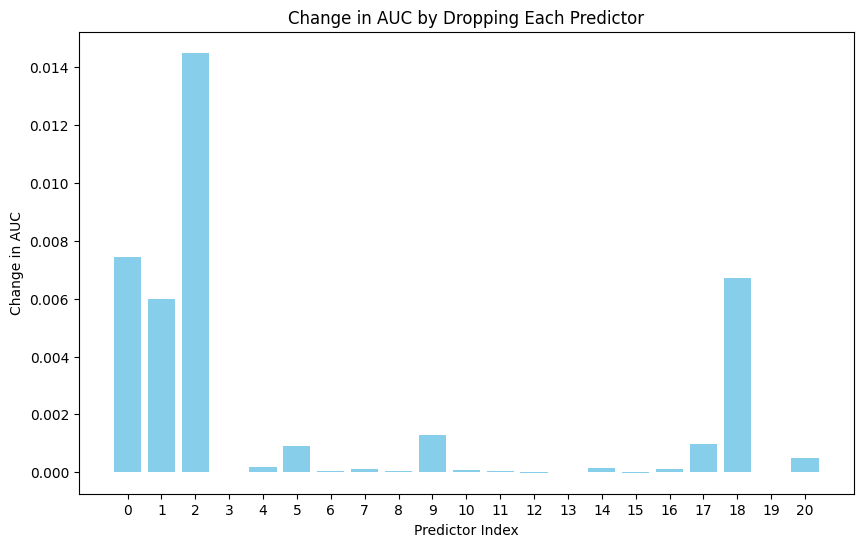

In [24]:
import matplotlib.pyplot as plt

# Assuming auc_changes is a list containing the change in AUC for each predictor
# and predictors is a list containing the names or indices of the predictors

# Create a bar plot to visualize the change in AUC for each predictor
plt.figure(figsize=(10, 6))
plt.bar(range(len(auc_changes)), auc_changes, color='skyblue')
plt.xlabel('Predictor Index')
plt.ylabel('Change in AUC')
plt.title('Change in AUC by Dropping Each Predictor')
plt.xticks(range(len(auc_changes)), column_names, rotation=45, ha='right')
plt.tight_layout()
plt.show()

NameError: name 'initial_auc' is not defined

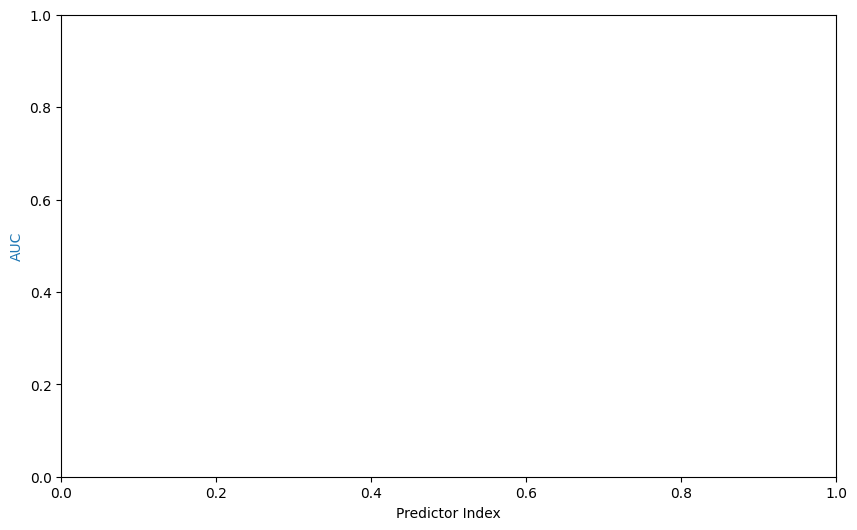

In [25]:
import matplotlib.pyplot as plt

# Assuming initial_auc is the initial AUC score and auc_changes is the list of changes in AUC
# Also assuming predictors is a list containing the names or indices of the predictors

# Create a figure with two subplots
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the AUC scores on the first y-axis (left)
color = 'tab:blue'
ax1.set_xlabel('Predictor Index')
ax1.set_ylabel('AUC', color=color)
ax1.plot(range(len(auc_changes)), [initial_auc] * len(auc_changes), '--', color='gray', label='Initial AUC')
ax1.plot(range(len(auc_changes)), auc_scores, marker='o', color=color, label='AUC Score')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

# Create a second y-axis for the change in AUC on the right side
ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Change in AUC', color=color)
ax2.bar(range(len(auc_changes)), auc_changes, color=color, label='Change in AUC')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

# Set x-axis ticks and labels
plt.xticks(range(len(auc_changes)), predictors, rotation=45, ha='right')

# Add title
plt.title('AUC Scores and Change in AUC by Dropping Each Predictor')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

# Question 2: Build a SVM

In [15]:
# Next we implement gradient boosting, in particular the Adaboost algorithm.
# Remember, gradient boosting algorithms involve iteratively improving the decision trees
# and hence involve a learning rate similar to logistic regressions.
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier

bdt = AdaBoostClassifier(
    # n_estimators is the number of trees
    tree.DecisionTreeClassifier(max_depth=1), algorithm="SAMME", n_estimators=2000, learning_rate=1
)
bdt.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=1, n_estimators=2000)

In [16]:
preds = bdt.predict(X_test)
print(np.sum(preds == y_test)/len(preds))

0.8652436140018922


In [17]:
# Pickle the AdaBoostClassifier object
with open('adaboost_classifier.pkl', 'wb') as f:
    pickle.dump(bdt, f)

In [18]:
# Unpickle the AdaBoostClassifier object
with open('adaboost_classifier.pkl', 'rb') as f:
    adaboost_classifier = pickle.load(f)

In [19]:
adaboost_classifier

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=1, n_estimators=2000)

### Handling Categorical Variables:

1. For "Biological sex" and "Zodiac sign," you can use one-hot encoding. This will create binary columns for each category, where 1 indicates the presence of that category and 0 indicates its absence.
For "Age bracket," "Education bracket," and "Income bracket," since they are ordinal categorical variables, you might consider ordinal encoding, where each category is mapped to an integer.
Handling Continuous Variables:

2. For continuous variables like "Body Mass Index" and "General health," you can use standardization or normalization to scale them appropriately.
Standardization (also known as Z-score normalization) transforms the data to have a mean of 0 and a standard deviation of 1. This is suitable when the data follows a Gaussian distribution.
Normalization scales the data to a range between 0 and 1. This is useful when the distribution of the data is not Gaussian and when you have outliers.
Handling Binary Variables:

3. Binary variables like "Diabetes status" and "High blood pressure" are already in a suitable format for many machine learning algorithms.